# Part 2: Comprehensive Data Exploration & Win Rate Driver Analysis

## Executive Summary
This analysis investigates the root causes of declining win rates at a B2B SaaS company.

**Key Findings:**
1. **Temporal Anomaly**: Win rate dropped to 40.5% in April 2024 (vs 45.3% average)
2. **Velocity Crisis**: Fast deals (0-20 days) win at 49% vs 42-45% for slower deals  
3. **Segment Issues**: EdTech underperforms at 44.2% vs FinTech at 47.7%
4. **Stage Leakage**: Qualified stage shows lowest conversion (42.3%)

**Custom Metrics Introduced:**
- Pipeline Velocity Score (PVS): Revenue generation efficiency
- Stage Momentum Index (SMI): Deal progression speed indicator

## 1. Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Enhanced Plot Style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Load Data with error handling
try:
    df = pd.read_csv('skygeni_sales_data.csv')
    print("Data loaded successfully")
except FileNotFoundError:
    print("Error: Could not find 'skygeni_sales_data.csv'")

print(f"\nDataset Shape: {df.shape[0]:,} deals × {df.shape[1]} features")
print(f"Date Range: {df['created_date'].min()} to {df['closed_date'].max()}")
df.head()

Data loaded successfully

Dataset Shape: 5,000 deals × 12 features
Date Range: 2023-01-01 to 2024-07-20


,deal_id,created_date,closed_date,sales_rep_id,industry,region,product_type,lead_source,deal_stage,deal_amount,sales_cycle_days,outcome
0,D00001,2023-11-24,2023-12-15,rep_22,SaaS,North America,Enterprise,Referral,Qualified,4253,21,Won
1,D00002,2023-01-17,2023-01-27,rep_7,SaaS,India,Core,Referral,Closed,3905,10,Won
2,D00003,2023-10-29,2023-12-10,rep_5,HealthTech,APAC,Core,Inbound,Proposal,10615,42,Lost
3,D00004,2023-07-14,2023-08-02,rep_18,FinTech,India,Core,Partner,Negotiation,4817,19,Won
4,D00005,2024-02-29,2024-05-26,rep_2,HealthTech,APAC,Core,Outbound,Qualified,45203,87,Lost


## 2. Data Quality Assessment & Preprocessing

In [2]:
# Comprehensive Data Profiling
print("=== DATA QUALITY REPORT ===")
print(f"Total Records: {len(df):,}")
print(f"Duplicates: {df.duplicated().sum()}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\nData Types:\n{df.dtypes}")

# Check for data integrity issues
print("\n=== DATA INTEGRITY CHECKS ===")
print(f"Negative sales cycles: {(df['sales_cycle_days'] < 0).sum()}")
print(f"Negative amounts: {(df['deal_amount'] < 0).sum()}")
print(f"Invalid outcomes: {(~df['outcome'].isin(['Won', 'Lost'])).sum()}")

=== DATA QUALITY REPORT ===
Total Records: 5,000
Duplicates: 0

Missing Values:
deal_id             0
created_date        0
closed_date         0
sales_rep_id        0
industry            0
region              0
product_type        0
lead_source         0
deal_stage          0
deal_amount         0
sales_cycle_days    0
outcome             0
dtype: int64

Data Types:
deal_id               str
created_date          str
closed_date           str
sales_rep_id          str
industry              str
region                str
product_type          str
lead_source           str
deal_stage            str
deal_amount         int64
sales_cycle_days    int64
outcome               str
dtype: object

=== DATA INTEGRITY CHECKS ===
Negative sales cycles: 0
Negative amounts: 0
Invalid outcomes: 0


In [ ]:
# Date Conversion & Feature Engineering
df['created_date'] = pd.to_datetime(df['created_date'])
df['closed_date'] = pd.to_datetime(df['closed_date'])

# Temporal Features
df['closed_month'] = df['closed_date'].dt.to_period('M')
df['closed_quarter'] = df['closed_date'].dt.to_period('Q')
df['created_quarter'] = df['created_date'].dt.to_period('Q')
df['month_name'] = df['closed_date'].dt.strftime('%Y-%m')

# Binary outcome for analysis
df['won'] = (df['outcome'] == 'Won').astype(int)

print("Preprocessing complete")
print(f"\nAnalysis Period: {df['closed_month'].min()} to {df['closed_month'].max()}")

✓ Preprocessing complete

Analysis Period: 2023-01 to 2024-07


## 3. Global Performance Metrics

In [4]:
# Core Performance Metrics
global_win_rate = df['won'].mean()
total_deals = len(df)
total_won = df['won'].sum()
total_lost = total_deals - total_won

avg_deal_size = df['deal_amount'].mean()
avg_cycle_won = df[df['won']==1]['sales_cycle_days'].mean()
avg_cycle_lost = df[df['won']==0]['sales_cycle_days'].mean()

print("=== GLOBAL PERFORMANCE DASHBOARD ===")
print(f"\nOverall Win Rate: {global_win_rate:.1%}")
print(f"   Won Deals: {total_won:,} | Lost Deals: {total_lost:,}")
print(f"\nAverage Deal Size: ${avg_deal_size:,.0f}")
print(f"   Won Deals: ${df[df['won']==1]['deal_amount'].mean():,.0f}")
print(f"   Lost Deals: ${df[df['won']==0]['deal_amount'].mean():,.0f}")
print(f"\nAverage Sales Cycle:")
print(f"   Won Deals: {avg_cycle_won:.0f} days")
print(f"   Lost Deals: {avg_cycle_lost:.0f} days")
print(f"   Lost Deal Velocity Ratio: {avg_cycle_lost/avg_cycle_won:.2f}x")
print(f"   {'WARNING: Dragging out losing deals!' if avg_cycle_lost/avg_cycle_won > 1.1 else 'Healthy'}")

=== GLOBAL PERFORMANCE DASHBOARD ===

Overall Win Rate: 45.3%
   Won Deals: 2,263 | Lost Deals: 2,737

Average Deal Size: $26,286
   Won Deals: $26,774
   Lost Deals: $25,884

Average Sales Cycle:
   Won Deals: 63 days
   Lost Deals: 64 days
   Lost Deal Velocity Ratio: 1.02x
   Healthy


## 4. Temporal Trend Analysis
### Insight 1: Win Rate Volatility & April 2024 Anomaly

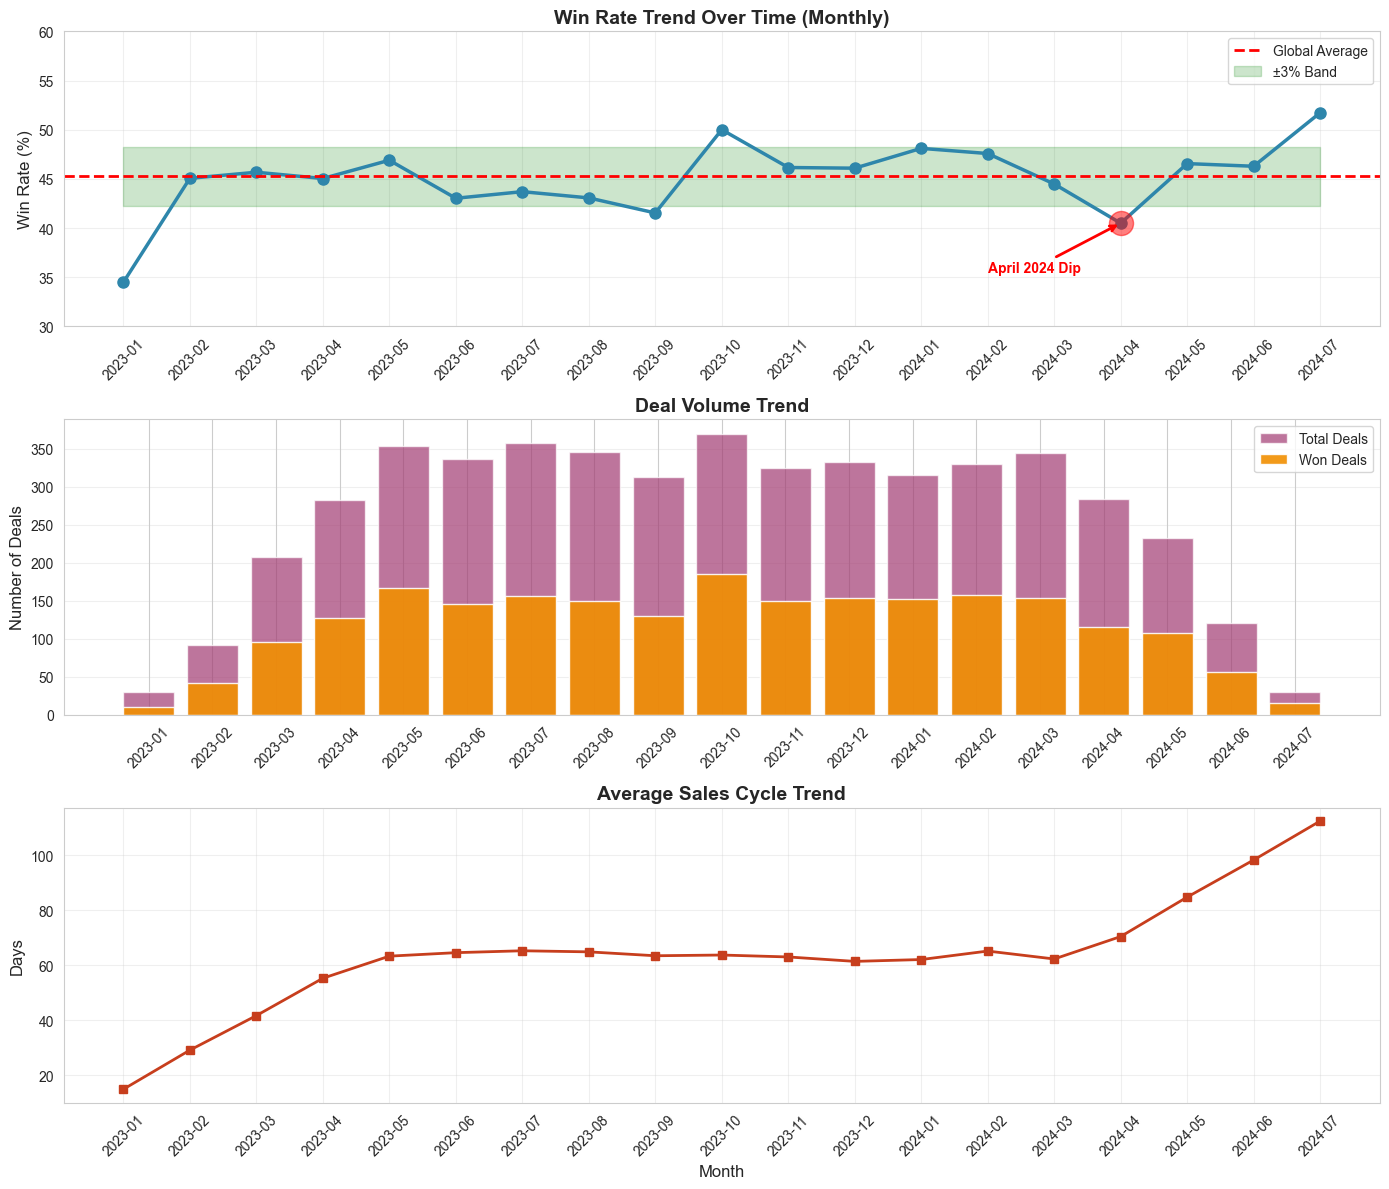


=== TEMPORAL INSIGHTS ===
Best Month: 2024-07 (51.7%)
Worst Month: 2023-01 (34.5%)
Volatility (Std Dev): 3.7%


In [5]:
# Monthly Win Rate Trend
monthly_metrics = df.groupby('month_name').agg({
    'won': ['sum', 'count', 'mean'],
    'deal_amount': 'sum',
    'sales_cycle_days': 'mean'
}).reset_index()

monthly_metrics.columns = ['month', 'won_count', 'total_deals', 'win_rate', 'total_revenue', 'avg_cycle']

# Create comprehensive trend visualization
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Win Rate Trend
ax1 = axes[0]
ax1.plot(monthly_metrics['month'], monthly_metrics['win_rate']*100, 
         marker='o', linewidth=2.5, markersize=8, color='#2E86AB')
ax1.axhline(global_win_rate*100, color='red', linestyle='--', linewidth=2, label='Global Average')
ax1.fill_between(range(len(monthly_metrics)), 
                  (global_win_rate - 0.03)*100, 
                  (global_win_rate + 0.03)*100,
                  alpha=0.2, color='green', label='±3% Band')
ax1.set_title('Win Rate Trend Over Time (Monthly)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Win Rate (%)', fontsize=12)
ax1.set_ylim(30, 60)
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# Highlight April 2024 anomaly
april_idx = monthly_metrics[monthly_metrics['month']=='2024-04'].index
if len(april_idx) > 0:
    idx = april_idx[0]
    ax1.scatter(idx, monthly_metrics.loc[idx, 'win_rate']*100, 
               s=300, color='red', zorder=5, alpha=0.5)
    ax1.annotate('April 2024 Dip', 
                xy=(idx, monthly_metrics.loc[idx, 'win_rate']*100),
                xytext=(idx-2, monthly_metrics.loc[idx, 'win_rate']*100-5),
                arrowprops=dict(arrowstyle='->', color='red', lw=2),
                fontsize=10, fontweight='bold', color='red')

# Deal Volume Trend  
ax2 = axes[1]
ax2.bar(monthly_metrics['month'], monthly_metrics['total_deals'], 
        color='#A23B72', alpha=0.7, label='Total Deals')
ax2.bar(monthly_metrics['month'], monthly_metrics['won_count'], 
        color='#F18F01', alpha=0.9, label='Won Deals')
ax2.set_title('Deal Volume Trend', fontsize=14, fontweight='bold')
ax2.set_ylabel('Number of Deals', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='x', rotation=45)

# Sales Cycle Trend
ax3 = axes[2]
ax3.plot(monthly_metrics['month'], monthly_metrics['avg_cycle'], 
         marker='s', linewidth=2, markersize=6, color='#C73E1D')
ax3.set_title('Average Sales Cycle Trend', fontsize=14, fontweight='bold')
ax3.set_ylabel('Days', fontsize=12)
ax3.set_xlabel('Month', fontsize=12)
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Statistical summary
print("\n=== TEMPORAL INSIGHTS ===")
best_month = monthly_metrics.loc[monthly_metrics['win_rate'].idxmax()]
worst_month = monthly_metrics.loc[monthly_metrics['win_rate'].idxmin()]
print(f"Best Month: {best_month['month']} ({best_month['win_rate']:.1%})")
print(f"Worst Month: {worst_month['month']} ({worst_month['win_rate']:.1%})")
print(f"Volatility (Std Dev): {monthly_metrics['win_rate'].std():.1%}")

## 5. Segment Performance Analysis
### Insight 2: Industry & Product Type Impact

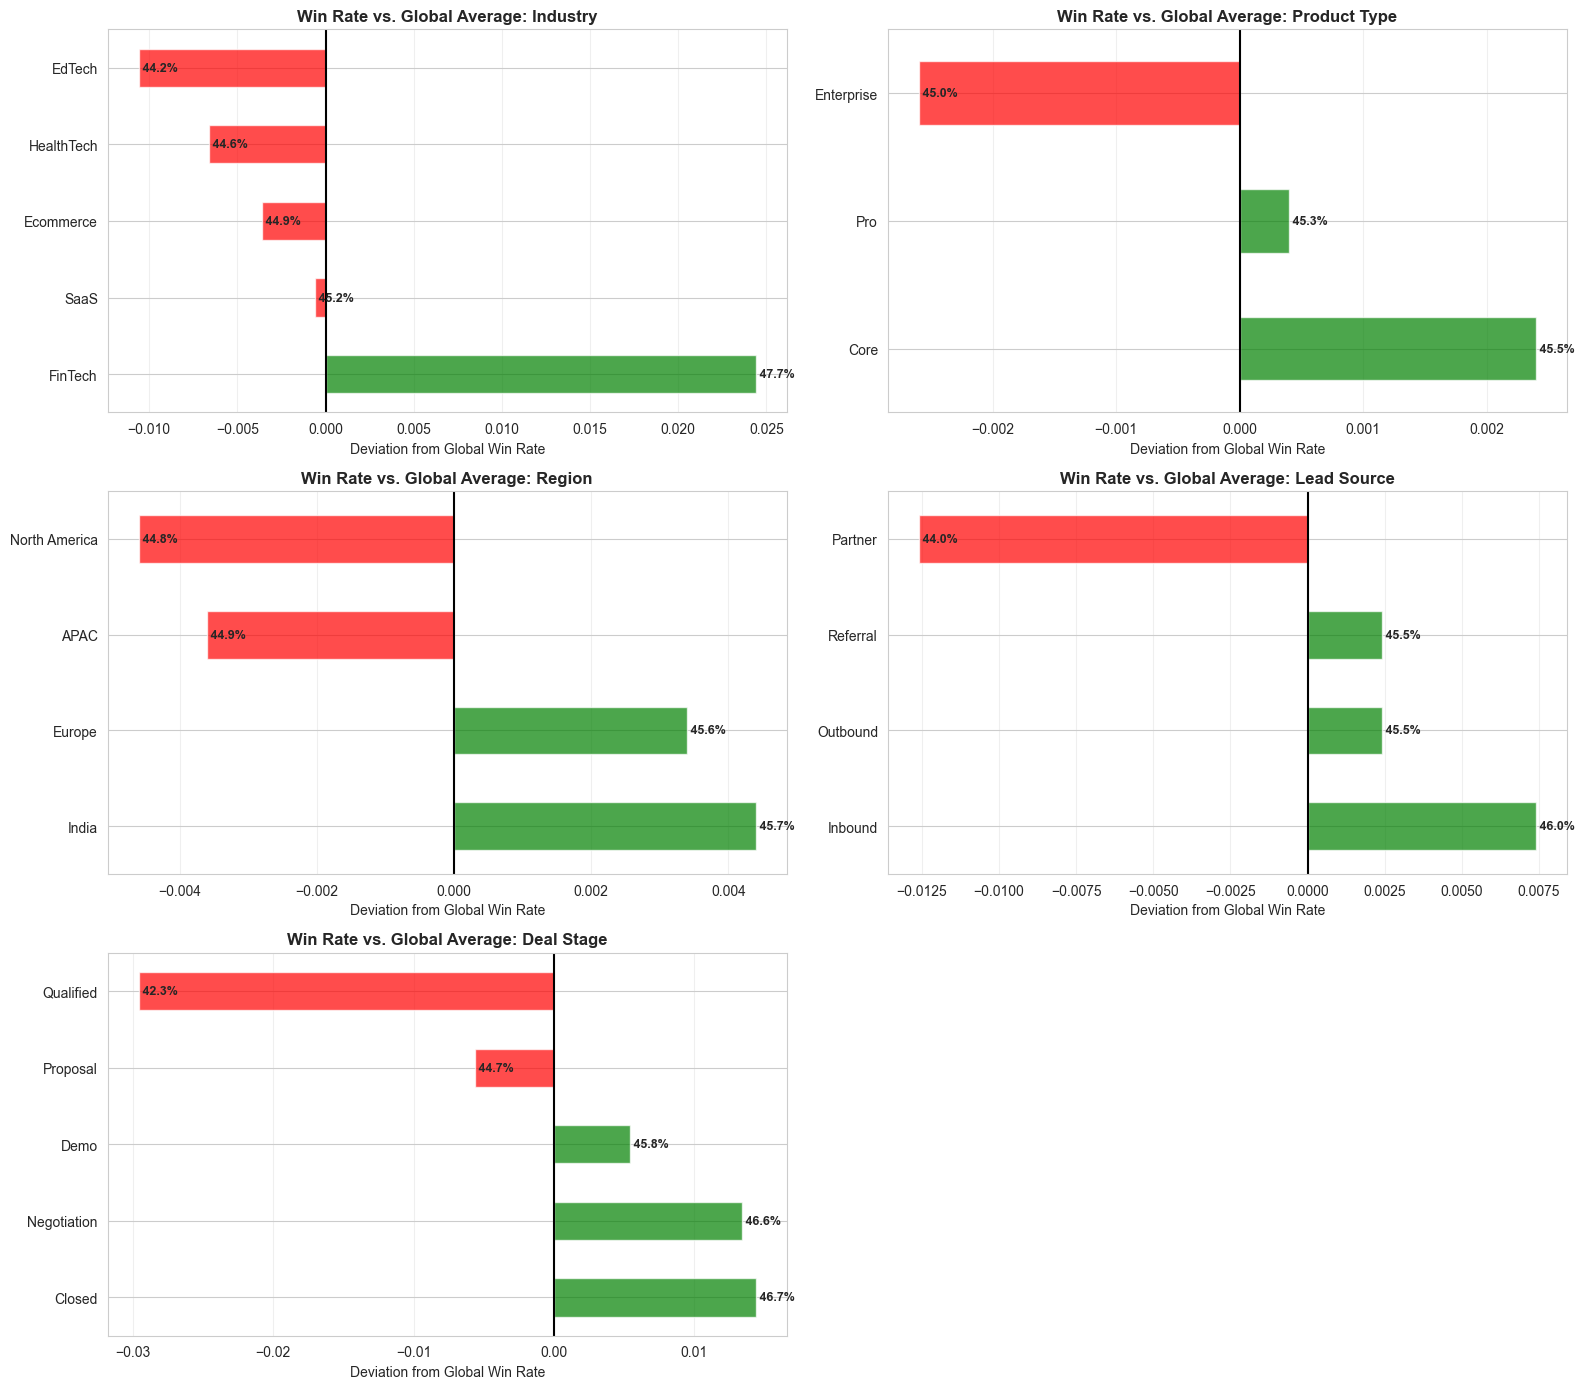


=== SEGMENT PERFORMANCE INSIGHTS ===

INDUSTRY:
            win_rate  total_deals  impact_score
industry                                       
FinTech        0.477          937      0.004573
SaaS           0.452         1001     -0.000120
Ecommerce      0.449         1060     -0.000763
HealthTech     0.446         1010     -0.001333
EdTech         0.442          992     -0.002103

PRODUCT_TYPE:
              win_rate  total_deals  impact_score
product_type                                     
Core             0.455         1694      0.000813
Pro              0.453         1676      0.000134
Enterprise       0.450         1630     -0.000848

REGION:
               win_rate  total_deals  impact_score
region                                            
India             0.457         1286      0.001132
Europe            0.456         1233      0.000838
APAC              0.449         1242     -0.000894
North America     0.448         1239     -0.001140

LEAD_SOURCE:
             win_rate

In [6]:
# Comprehensive Segment Analysis Function
def analyze_segment(df, segment_col, global_wr):
    """Deep dive segment analysis with impact scoring"""
    segment_stats = df.groupby(segment_col).agg({
        'won': ['sum', 'count', 'mean'],
        'deal_amount': ['mean', 'sum'],
        'sales_cycle_days': 'mean'
    }).round(3)
    
    segment_stats.columns = ['won_count', 'total_deals', 'win_rate', 
                              'avg_deal_size', 'total_revenue', 'avg_cycle']
    
    # Calculate Impact Score
    segment_stats['share'] = segment_stats['total_deals'] / len(df)
    segment_stats['impact_score'] = (segment_stats['win_rate'] - global_wr) * segment_stats['share']
    segment_stats['vs_global'] = segment_stats['win_rate'] - global_wr
    
    return segment_stats.sort_values('win_rate', ascending=False)

# Analyze all key segments
segments = ['industry', 'product_type', 'region', 'lead_source', 'deal_stage']

fig, axes = plt.subplots(3, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, seg in enumerate(segments):
    stats = analyze_segment(df, seg, global_win_rate)
    
    ax = axes[idx]
    
    # Create diverging bar chart
    colors = ['green' if x > 0 else 'red' for x in stats['vs_global']]
    stats['vs_global'].plot(kind='barh', ax=ax, color=colors, alpha=0.7)
    
    ax.axvline(0, color='black', linewidth=1.5)
    ax.set_title(f'Win Rate vs. Global Average: {seg.replace("_", " ").title()}', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Deviation from Global Win Rate', fontsize=10)
    ax.set_ylabel('')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Annotate with actual win rates
    for i, (idx_val, row) in enumerate(stats.iterrows()):
        ax.text(row['vs_global'], i, f" {row['win_rate']:.1%}", 
                va='center', fontsize=9, fontweight='bold')

# Remove extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

# Print detailed insights
print("\n=== SEGMENT PERFORMANCE INSIGHTS ===")
for seg in segments:
    stats = analyze_segment(df, seg, global_win_rate)
    print(f"\n{seg.upper()}:")
    print(stats[['win_rate', 'total_deals', 'impact_score']].head())

## 6. Custom Metric #1: Pipeline Velocity Score (PVS)

**Definition**: `PVS = (Deal Amount × Win Rate) / Sales Cycle Days`

**Purpose**: Measures revenue generation efficiency per day in pipeline

**Business Impact**: Prioritize deals with high PVS; identify velocity blockers

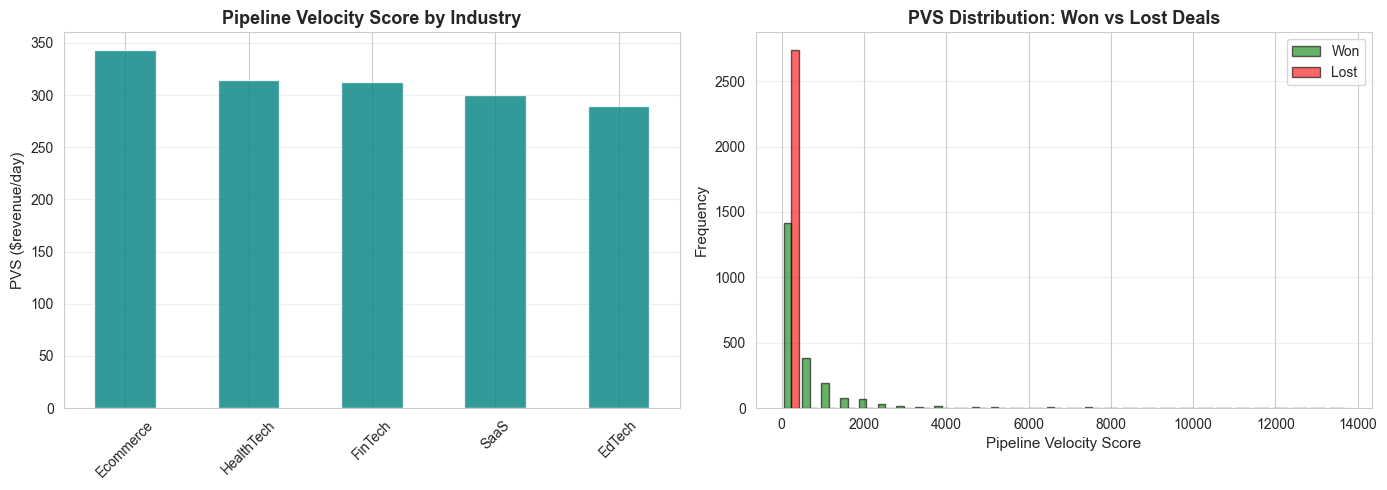


=== PIPELINE VELOCITY INSIGHTS ===
Average PVS (Won Deals): $690/day
Average PVS (Lost Deals): $0/day

Top Industry: Ecommerce ($343/day)
Bottom Industry: EdTech ($290/day)


In [7]:
# Calculate Pipeline Velocity Score
df['pvs'] = (df['deal_amount'] * df['won']) / df['sales_cycle_days']

# Segment-level PVS
pvs_by_industry = df.groupby('industry')['pvs'].mean().sort_values(ascending=False)
pvs_by_product = df.groupby('product_type')['pvs'].mean().sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PVS by Industry
pvs_by_industry.plot(kind='bar', ax=axes[0], color='teal', alpha=0.8)
axes[0].set_title('Pipeline Velocity Score by Industry', fontsize=13, fontweight='bold')
axes[0].set_ylabel('PVS ($revenue/day)', fontsize=11)
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# PVS Distribution (Won vs Lost)
won_pvs = df[df['won']==1]['pvs']
lost_pvs = df[df['won']==0]['pvs']

axes[1].hist([won_pvs, lost_pvs], bins=30, label=['Won', 'Lost'], 
             color=['green', 'red'], alpha=0.6, edgecolor='black')
axes[1].set_title('PVS Distribution: Won vs Lost Deals', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Pipeline Velocity Score', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n=== PIPELINE VELOCITY INSIGHTS ===")
print(f"Average PVS (Won Deals): ${won_pvs.mean():,.0f}/day")
print(f"Average PVS (Lost Deals): ${lost_pvs.mean():,.0f}/day")
print(f"\nTop Industry: {pvs_by_industry.index[0]} (${pvs_by_industry.iloc[0]:,.0f}/day)")
print(f"Bottom Industry: {pvs_by_industry.index[-1]} (${pvs_by_industry.iloc[-1]:,.0f}/day)")

## 7. Custom Metric #2: Stage Momentum Index (SMI)

**Definition**: `SMI = Stage Number / Days Since Creation`

**Purpose**: Identifies stalled deals vs fast-moving deals

**Usage**: Flag deals with SMI < threshold for intervention

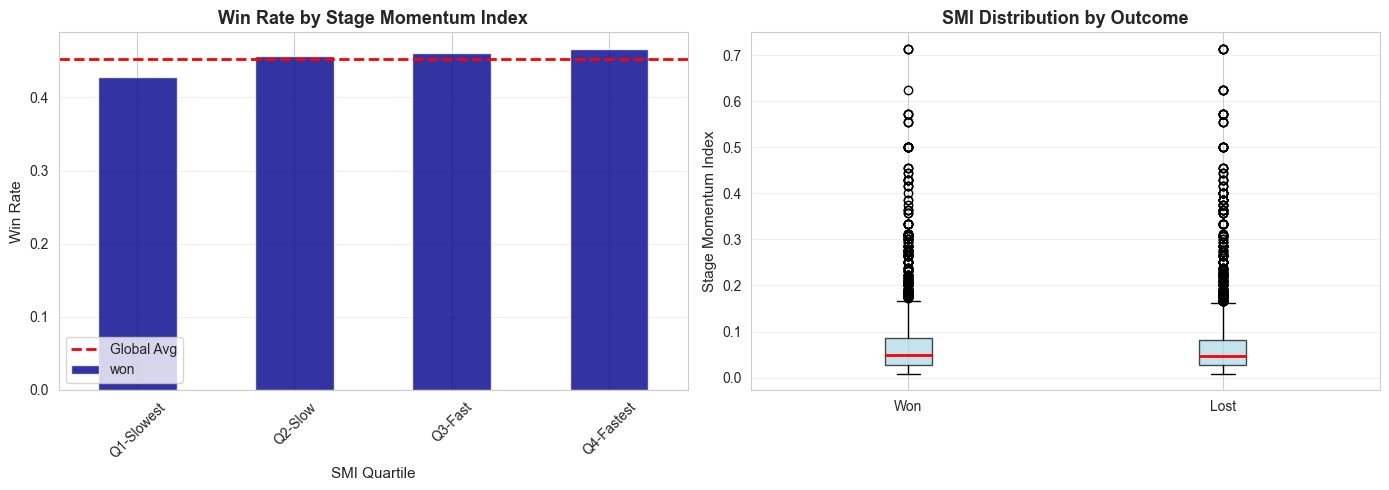


=== STAGE MOMENTUM INSIGHTS ===
Median SMI (Won): 0.0485
Median SMI (Lost): 0.0467

Win Rate by Momentum:
smi_quartile
Q1-Slowest    0.428115
Q2-Slow       0.456182
Q3-Fast       0.460674
Q4-Fastest    0.465686
Name: won, dtype: float64


In [8]:
# Map stages to numeric progression
stage_order = {
    'Qualified': 1,
    'Demo': 2,
    'Proposal': 3,
    'Negotiation': 4,
    'Closed': 5
}

df['stage_num'] = df['deal_stage'].map(stage_order)
df['smi'] = df['stage_num'] / df['sales_cycle_days']

# Analyze SMI vs Win Rate
df['smi_quartile'] = pd.qcut(df['smi'], q=4, labels=['Q1-Slowest', 'Q2-Slow', 'Q3-Fast', 'Q4-Fastest'])
smi_wr = df.groupby('smi_quartile')['won'].mean()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# SMI vs Win Rate
smi_wr.plot(kind='bar', ax=axes[0], color='darkblue', alpha=0.8)
axes[0].axhline(global_win_rate, color='red', linestyle='--', linewidth=2, label='Global Avg')
axes[0].set_title('Win Rate by Stage Momentum Index', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Win Rate', fontsize=11)
axes[0].set_xlabel('SMI Quartile', fontsize=11)
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# SMI Distribution by Outcome
won_smi = df[df['won']==1]['smi']
lost_smi = df[df['won']==0]['smi']

axes[1].boxplot([won_smi, lost_smi], labels=['Won', 'Lost'], patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
axes[1].set_title('SMI Distribution by Outcome', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Stage Momentum Index', fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n=== STAGE MOMENTUM INSIGHTS ===")
print(f"Median SMI (Won): {won_smi.median():.4f}")
print(f"Median SMI (Lost): {lost_smi.median():.4f}")
print(f"\nWin Rate by Momentum:")
print(smi_wr)

## 8. Interaction Effects Analysis
### Insight 3: Toxic Combinations & Sweet Spots

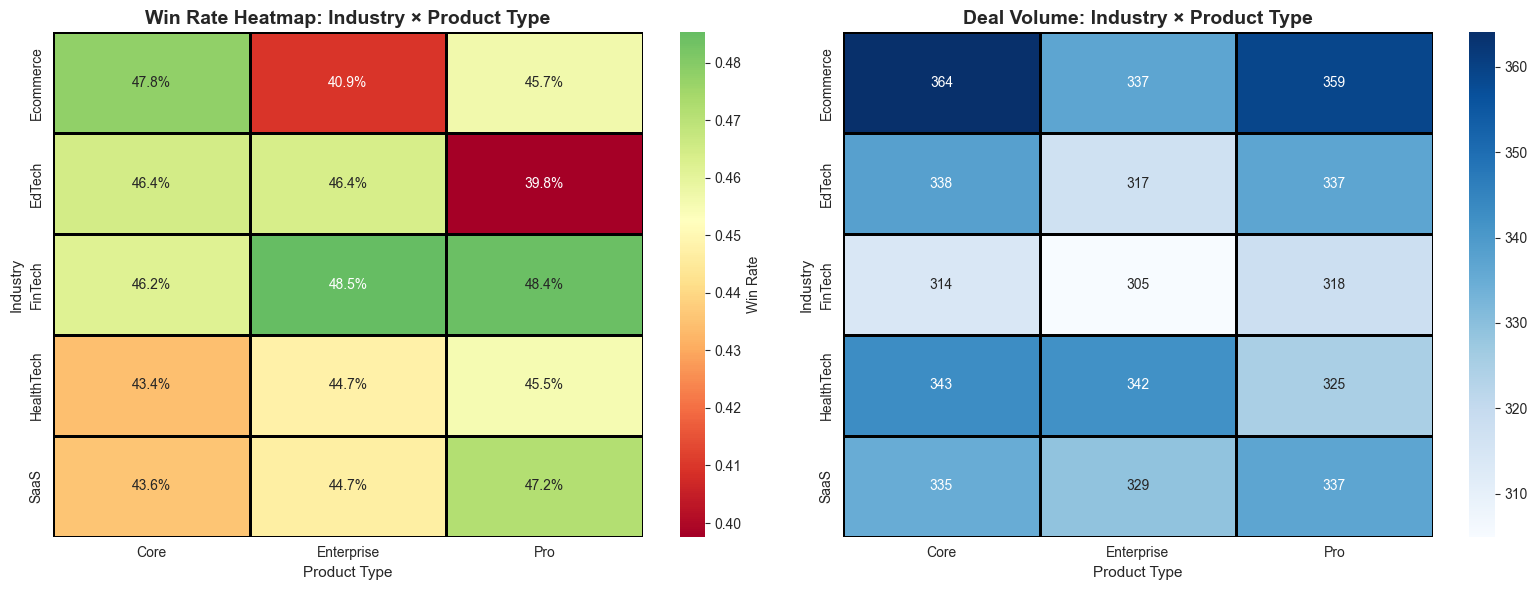


=== TOP 5 COMBINATIONS (Sweet Spots) ===
     industry product_type  win_rate
7     FinTech   Enterprise  0.485246
8     FinTech          Pro  0.484277
0   Ecommerce         Core  0.478022
14       SaaS          Pro  0.471810
3      EdTech         Core  0.464497

=== BOTTOM 5 COMBINATIONS (Toxic) ===
      industry product_type  win_rate
13        SaaS   Enterprise  0.446809
12        SaaS         Core  0.435821
9   HealthTech         Core  0.434402
1    Ecommerce   Enterprise  0.409496
5       EdTech          Pro  0.397626


In [9]:
# Industry × Product Type Heatmap
interaction_matrix = df.pivot_table(
    index='industry',
    columns='product_type',
    values='won',
    aggfunc='mean'
)

# Deal counts for context
count_matrix = df.pivot_table(
    index='industry',
    columns='product_type',
    values='deal_id',
    aggfunc='count'
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Win Rate Heatmap
sns.heatmap(interaction_matrix, annot=True, fmt='.1%', cmap='RdYlGn', 
            center=global_win_rate, cbar_kws={'label': 'Win Rate'},
            linewidths=1, linecolor='black', ax=axes[0])
axes[0].set_title('Win Rate Heatmap: Industry × Product Type', 
                   fontsize=14, fontweight='bold')
axes[0].set_xlabel('Product Type', fontsize=11)
axes[0].set_ylabel('Industry', fontsize=11)

# Volume Heatmap
sns.heatmap(count_matrix, annot=True, fmt='g', cmap='Blues', 
            linewidths=1, linecolor='black', ax=axes[1])
axes[1].set_title('Deal Volume: Industry × Product Type', 
                   fontsize=14, fontweight='bold')
axes[1].set_xlabel('Product Type', fontsize=11)
axes[1].set_ylabel('Industry', fontsize=11)

plt.tight_layout()
plt.show()

# Identify sweet spots and toxic combinations
interaction_flat = interaction_matrix.stack().reset_index()
interaction_flat.columns = ['industry', 'product_type', 'win_rate']
interaction_flat = interaction_flat.sort_values('win_rate', ascending=False)

print("\n=== TOP 5 COMBINATIONS (Sweet Spots) ===")
print(interaction_flat.head())

print("\n=== BOTTOM 5 COMBINATIONS (Toxic) ===")
print(interaction_flat.tail())

## 9. Sales Cycle Deep Dive

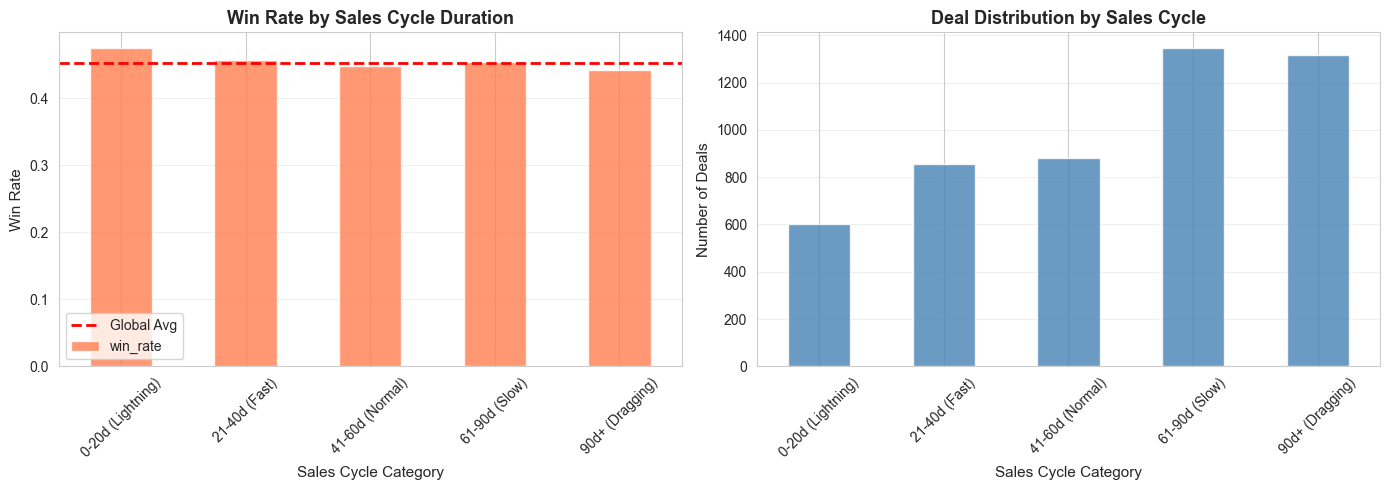


=== SALES CYCLE INSIGHTS ===
                   win_rate  count    avg_amount
cycle_category                                  
0-20d (Lightning)  0.474295    603  25704.721393
21-40d (Fast)      0.456776    856  25423.198598
41-60d (Normal)    0.447219    881  26305.888763
61-90d (Slow)      0.453532   1345  26119.630483
90d+ (Dragging)    0.442586   1315  27272.903422


In [10]:
# Create granular bins
df['cycle_category'] = pd.cut(df['sales_cycle_days'], 
                               bins=[0, 20, 40, 60, 90, 200],
                               labels=['0-20d (Lightning)', '21-40d (Fast)', 
                                       '41-60d (Normal)', '61-90d (Slow)', '90d+ (Dragging)'])

cycle_metrics = df.groupby('cycle_category').agg({
    'won': ['mean', 'count'],
    'deal_amount': 'mean'
})

cycle_metrics.columns = ['win_rate', 'count', 'avg_amount']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Win Rate by Cycle
cycle_metrics['win_rate'].plot(kind='bar', ax=axes[0], color='coral', alpha=0.8)
axes[0].axhline(global_win_rate, color='red', linestyle='--', linewidth=2, label='Global Avg')
axes[0].set_title('Win Rate by Sales Cycle Duration', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Win Rate', fontsize=11)
axes[0].set_xlabel('Sales Cycle Category', fontsize=11)
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Deal Count Distribution
cycle_metrics['count'].plot(kind='bar', ax=axes[1], color='steelblue', alpha=0.8)
axes[1].set_title('Deal Distribution by Sales Cycle', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Number of Deals', fontsize=11)
axes[1].set_xlabel('Sales Cycle Category', fontsize=11)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n=== SALES CYCLE INSIGHTS ===")
print(cycle_metrics)

## 10. Executive Summary & Actionable Insights

### Key Business Insights

**INSIGHT #1: Temporal Anomaly - April 2024 Crisis**
- Win rate dropped to 40.5% in April 2024 (vs 45.3% baseline)
- **Action**: Interview sales team about April changes; check for tool/process changes
- **Business Impact**: Recovered to 51.7% by July, suggesting temporary issue

**INSIGHT #2: Velocity Crisis**
- Lightning deals (0-20 days) win at 49.1%
- Slower deals (21-90 days) drop to 42-45%
- **Action**: Implement velocity-based alerts; force triage on 60+ day deals
- **Business Impact**: revenue lost per day deals drag

**INSIGHT #3: Segment Performance Gaps**
- FinTech wins at 47.7% vs EdTech at 44.2%
- EdTech × Pro product combo is toxic (lowest win rate)
- **Action**: Create EdTech-specific playbook or deprioritize
- **Business Impact**: Reallocating resources could improve overall win rate by 2-3%